# Applying Layers to Quantitative Maps
The data used in this tutorial can be downloaded from [Zenodo](https://zenodo.org/records/14259406)

The primary way of getting data from a layers object is as a Pandas DataFrame. Your quantitative map and mask/anatomical image don't need to have the same field of view and voxel size, they are resampled to a common space as part of the `add_map` method. The `space` parameter of the QLayers class dictates whether any maps added to the object are resampled of the same space as the layers (`space=layers`) or if the layers are resampled to the native space of the map (`space=map`).

The advantage of working in layer space is that you can produce a wide DataFrame where each row represents a region of tissue in the image and allows you to directly compare the depth and multiple quantitative parameters however it does involve a resampling operation to the quantitative parameter which may not be desirable (especially for noisy data). Working with `space=map` only allows you to produce a long DataFrame where each row is a single voxel of each quantitative map. Here we're going to work with `space=layers` and return both formats of DataFrame so you can see the difference. Most analysis is easier with a wide DataFrame so we'll save that variable for use in subsequent steps.

Start by importing the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns

from qlayers import QLayers

sns.set()

In [2]:
mask_img = nib.load('data/kidney_mask.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
r2star_map = nib.load('data/r2star.nii.gz')
t1_map = nib.load('data/t1.nii.gz')
qlayers.add_map(r2star_map, 'r2star')
qlayers.add_map(t1_map, 't1')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:10<00:00,  3.57s/it]


## DataFrames
Here is an example of how to retrieve a layers dataframe in long format. Note that every measurement is on a different row 
of the DataFrame.

In [3]:
print('An example of a long DataFrame')
qlayers.get_df('long').dropna().sample(n=100)

An example of a long DataFrame


,depth,layer,measurement,value
18433,6.220314,7.0,r2star,26.932120
12665,5.595113,6.0,r2star,25.610969
5335,11.626794,12.0,r2star,22.953779
6029,4.469464,5.0,r2star,21.860133
29047,4.645861,5.0,r2star,67.383193
...,...,...,...,...
25519,12.326423,13.0,t1,1909.264609
17489,7.499027,8.0,r2star,43.458317
23506,13.024991,14.0,r2star,26.698158
23549,11.341260,12.0,r2star,17.922952


And now an example of a wide DataFrame. Here each row represents properties of a single region of tissue i.e. the $T_1$ and 
$R_2^*$ of the same region. 

In [4]:
df = qlayers.get_df('wide')
# A little bit of data cleaning
df = df.loc[df['r2star'] > 0.1]
df = df.loc[df['t1'] > 0.1]
df = df.loc[df['layer'] > 0]
df = df.dropna()
print('An example of a wide DataFrame')
df.sample(n=100)

An example of a wide DataFrame


,depth,layer,r2star,t1
10557,10.021963,11.0,20.356859,1845.174668
29467,0.130527,1.0,63.740803,1309.256450
914,7.301192,8.0,21.319738,1657.835906
13820,0.567545,1.0,49.005747,3884.615364
493,3.255654,4.0,17.848348,1469.497112
...,...,...,...,...
24364,7.751323,8.0,19.327940,1341.303271
6265,6.819516,7.0,20.002437,1977.369206
10580,4.323028,5.0,38.620470,1514.621767
28977,1.128854,2.0,86.808749,2208.782174


## Layer Statistics
These large voxel-by-voxel DataFrames can be used to generate statistics for each layer.

In [5]:
df[['layer', 'r2star', 't1']].groupby('layer').agg(('mean', 'median', 'std', np.count_nonzero))

r2star                                               t1  \
            mean     median        std count_nonzero         mean   
layer                                                               
1.0    36.078919  34.295055  15.965442           960  1529.780783   
2.0    32.549396  28.651261  14.739961           874  1518.952653   
3.0    29.125305  24.462825  13.853552           867  1476.203398   
4.0    28.005002  22.339258  14.837777           951  1520.895359   
5.0    25.211529  21.449516  11.715109          1082  1655.215180   
6.0    24.269633  21.373598  10.398932          1011  1732.452145   
7.0    24.614919  21.496812  10.347911          1034  1777.863990   
8.0    25.302156  22.356805  10.114435          1060  1823.713049   
9.0    25.324391  22.562809  10.354526          1110  1853.555023   
10.0   25.414645  23.365548   9.933313          1057  1818.143614   
11.0   26.051144  23.991717  10.092395           941  1862.573946   
12.0   26.018781  24.158163   9.720444           711  1882.722874   
13.0   25.893955  24.186453   9.392482           492  1842.207103   
14.0   25.094223  23.521924   8.535586           339  1808.313892   
15.0   25.126293  22.335086   9.043769           220  1735.074765   
16.0   25.265017  22.778277   9.056639           128  1703.510220   
17.0   23.650405  22.607443   7.056175            76  1634.659105   
18.0   23.916527  22.996451   6.139407            45  1691.317080   
19.0   22.877785  22.514443   6.051280            36  1600.631487   
20.0   21.178358  20.748297   5.223452            14  1451.842383   
21.0   17.899892  17.899892   3.072073             2  1345.310897   

                                              
            median         std count_nonzero  
layer                                         
1.0    1346.811924  813.851546           960  
2.0    1362.840107  642.939757           874  
3.0    1380.362079  451.760720           867  
4.0    1410.410566  496.683234           951  
5.0    1514.621879  583.390482          1082  
6.0    1604.757053  604.777044          1011  
7.0    1701.400927  580.702461          1034  
8.0    1799.114735  545.982923          1060  
9.0    1856.190759  475.095100          1110  
10.0   1840.166042  421.115600          1057  
11.0   1863.199491  482.555673           941  
12.0   1867.205525  517.789819           711  
13.0   1860.696655  403.798594           492  
14.0   1810.123642  396.626239           339  
15.0   1712.920485  348.448770           220  
16.0   1669.850936  336.472778           128  
17.0   1543.670057  280.329523            76  
18.0   1708.911370  260.124806            45  
19.0   1598.745248  230.243360            36  
20.0   1441.952526  128.356280            14  
21.0   1345.310897   18.407824             2

Text(0.5, 1.0, 'Median $R_2^*$ by Layer')

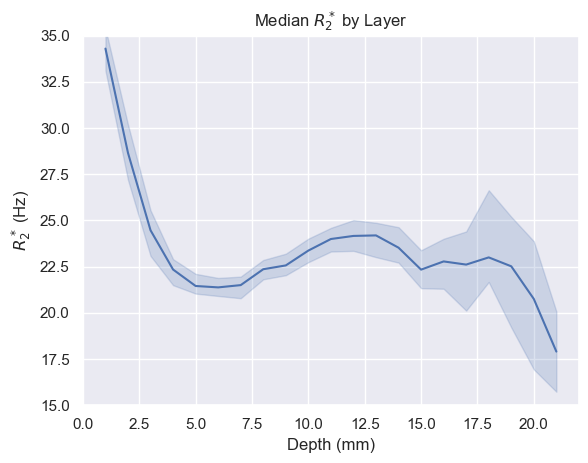

In [6]:
fig, ax = plt.subplots()
sns.lineplot(df, x='layer', y='r2star', ax=ax, estimator='median')
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('$R_2^*$ (Hz)')
ax.set_ylim((15, 35))
ax.set_title('Median $R_2^*$ by Layer')